In [55]:
import numpy as np
import glob2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import logging
import random
from numba import cuda
import math

In [2]:
# logging.basicConfig(filename='./log.log',level=10, filemode = 'w', force=True, format='%(asctime)s   %(funcName)s - %(levelname)s:%(message)s')

# Read data

In [3]:
def read_data(link_cat, link_dog, n_samples, image_size = (400, 400), random_state = 42):
    list_cat = glob2.glob(link_cat)
    list_dog = glob2.glob(link_dog)
    cat_images = []
    cat_labels = []
    for i in range(n_samples):
        if 'jpg' in list_cat[i]:
            img = Image.open(list_cat[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                cat_images.append(np.array(img))
                cat_labels.append(1)
    dog_images = []
    dog_labels = []
    for i in range(n_samples):
        if 'jpg' in list_dog[i]:
            img = Image.open(list_dog[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                dog_images.append(np.array(img))
                dog_labels.append(-1)
    for index in range(len(cat_images)):
        if cat_images[index].shape[2] != 3:
            print(index, cat_images[index].shape[2])
    for index in range(len(dog_images)):
        if dog_images[index].shape[2] != 3:
            print(index, dog_images[index].shape[2])  
    cat_images = np.array(cat_images)
    cat_labels = np.array(cat_labels)
    dog_images = np.array(dog_images)
    dog_labels = np.array(dog_labels)
    
    x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(cat_images, cat_labels, test_size=0.3, random_state = random_state)
    x_dog_train, x_dog_test, y_dog_train, y_dog_test = train_test_split(dog_images, dog_labels, test_size=0.3, random_state = random_state)
    X_train = np.concatenate((x_cat_train, x_dog_train), axis = 0)
    y_train = np.concatenate((y_cat_train, y_dog_train), axis = 0)
    X_test = np.concatenate((x_cat_test, x_dog_test), axis = 0)
    y_test = np.concatenate((y_cat_test, y_dog_test), axis = 0)

    s1 = np.arange(X_train.shape[0])
    random.Random(0).shuffle(s1)
    X_train = X_train.take(s1, axis = 0)
    y_train = y_train.take(s1, axis = 0)
    s2  = np.arange(X_test.shape[0])
    random.Random(5).shuffle(s2)
    X_test = X_test.take(s2, axis = 0)
    y_test = y_test.take(s2, axis = 0)
    
    return X_train, y_train, X_test, y_test

# SVM

In [4]:
class SVM_NEW:
    def __init__(self, gamma = -1, kernel = 'rbf', C = 1.0, eps = 1e-3):
        self.C = C
        self.eps = eps
        self.gamma = gamma
        self.tau = 1e-12
        self.kernel = kernel
        self.gamma = gamma
    
    def Kernel(self, x1, x2):
        if self.kernel == 'rbf':
            return self.rbf(x1, x2)
        if self.kernel == 'linear':
            return self.linear(x1, x2)

    def get_Q(self, X, i, j):
        if self.Q[i, j] == None:
            self.Q[i][j] = self.y[i] * self.y[j] * self.get_K(X, i, j)
            self.Q[j][i] = self.Q[i][j]
        return self.Q[i][j]
    
    def get_K(self, X, i, j):
        if self.K[i, j] == None:
            self.K[i][j] = self.Kernel(X[i], X[j])
            self.K[j][i] = self.K[i][j]
        return self.K[i][j]
    
    def linear(self, x1, x2):
        x1_temp = x1.astype(np.float64)
        x2_temp = x2.astype(np.float64)
        return x1_temp.dot(x2_temp)
    
    def rbf(self, x1, x2):
        x1_temp = x1.astype(np.float64)
        x2_temp = x2.astype(np.float64)
        return np.exp(-self.gamma * (x1_temp.dot(x1_temp) + x2_temp.dot(x2_temp) - 2.0 * x1_temp.dot(x2_temp)))
        
    def select_B(self, X):
        i = -1
        G_max = -np.inf
        G_min = np.inf
        for t in range(self.l):
            if (self.y[t] == 1 and self.alphas[t] <self.C) or \
            (self.y[t] == -1 and self.alphas[t] > 0):
                if -self.y[t] * self.G[t] >= G_max:
                    i = t
                    G_max = -self.y[t] * self.G[t]
        j = -1
        obj_min = np.inf
        for t in range(self.l):
            if (self.y[t]==1 and self.alphas[t]>0) or \
                (self.y[t] == -1 and self.alphas[t] < self.C):
                    b = G_max + self.y[t] * self.G[t]
                    if -self.y[t]*self.G[t] <= G_min:
                        G_min = -self.y[t] * self.G[t]
                    if b>0:
                        a = self.get_Q(X, i, i) + self.get_Q(X, t, t) - 2.0*self.y[i]*self.y[t]*self.get_Q(X, i, t)
                        if a<=0:
                            a = self.tau
                        if -(b*b)/a <= obj_min:
                            j = t
                            obj_min = -(b*b)/a
        if G_max - G_min < self.eps:
            return -1, -1
        return i, j

    def predict(self, X):
        pred = []
        for x in X:
            sum = 0.0
            for i in range(self.l):
                sum += self.y[i] * self.alphas[i] * self.Kernel(self.X[i], x)
            sum -= self.b
            pred.append(np.sign(sum))
        return pred

    def get_b(self):
        sum = 0.0
        count = 0
        for i in range(self.l):
            if 0 < self.alphas[i] < self.C:
                count += 1
                sum += self.y[i] * self.G[i]
        if count > 0:
            self.b = sum/count
            return
        max = -np.inf
        min = np.inf
        for i in range(self.l):
            if (self.alphas[i] == 0 and self.y[i] == -1) or \
                (self.alphas[i] == self.C and self.y[i] == 1):
                    if max < self.y[i] * self.G[i]:
                        max = self.y[i] * self.G[i]
            if (self.alphas[i] == 0 and self.y[i] == 1) or \
                (self.alphas[i] == self.C and self.y[i] == -1):
                    if min > self.y[i] *self.G[i]:
                        min = self.y[i] * self.G[i]
        self.b = (min+max) / 2

    def fit(self, X, y):
        self.y = y
        self.X = X
        self.l = len(y)
        if self.gamma == -1:
            self.gamma = 1/(X.shape[1]*X.var())
        self.active_size= self.l
        self.alphas = np.zeros(self.l)
        self.n_iter = 0

        self.K = np.array([[None for _ in range(self.l)] for _ in range(self.l)])
        self.Q = np.array([[None for _ in range(self.l)] for _ in range(self.l)])
        self.G = np.array([-1.0 for _ in range(self.l)])
        while True:
            i, j = self.select_B(X)
            if j == -1:
                break
            self.n_iter += 1
            alphai = self.alphas[i]
            alphaj = self.alphas[j]
            if y[i] != y[j]:
                quad_coef = self.get_Q(X, i, i) + self.get_Q(X, j, j) + 2*self.get_Q(X, i, j)
                if quad_coef <= 0:
                    quad_coef = self.tau
                delta = (-self.G[i] - self.G[j])/quad_coef
                diff = alphai - alphaj
                self.alphas[i] += delta
                self.alphas[j] += delta
                if diff > 0:
                    if self.alphas[j]<0:
                        self.alphas[j] = 0
                        self.alphas[i] = diff
                    if self.alphas[i]>self.C:
                        self.alphas[i] = self.C
                        self.alphas[j] = self.C - diff
                else:
                    if self.alphas[i]<0:
                        self.alphas[i] = 0
                        self.alphas[j] = -diff
                    if self.alphas[j]>self.C:
                        self.alphas[j] = self.C
                        self.alphas[i] = self.C + diff
            else:
                quad_coef = self.get_Q(X, i, i) + self.get_Q(X,j,j) - 2*self.get_Q(X,i,j)
                if quad_coef <=0:
                    quad_coef = self.tau
                delta = (self.G[i]-self.G[j])/quad_coef
                sum = alphai + alphaj
                self.alphas[i] -= delta
                self.alphas[j] += delta
                if sum>self.C:
                    if self.alphas[i]>self.C:
                        self.alphas[i] = self.C
                        self.alphas[j] = sum-self.C
                    if self.alphas[j]>self.C:
                        self.alphas[j] = self.C
                        self.alphas[i] = sum-self.C
                else:
                    if self.alphas[j]<0:
                        self.alphas[j] = 0
                        self.alphas[i] = sum
                    if self.alphas[i]<0:
                        self.alphas[i] = 0
                        self.alphas[j] = sum
            delta_ai = self.alphas[i] - alphai
            delta_aj = self.alphas[j] - alphaj
            
            for t in range(self.l):
                self.G[t] += self.get_Q(X, i, t) * delta_ai + self.get_Q(X, j, t) *delta_aj
        self.get_b()

# Temp svm

In [5]:
class SVM_2:
    def __init__(self, C, gamma, tau = 1e-12, eps = 1e-3):
        self.C = C
        self.eps = eps
        self.gamma = gamma
        self.tau = tau
    
    def stop(self, m, M):
        if m(self.alphas) - M(self.alphas) < self.eps:
            return True
        return False

    def get_Q(self, X, i, j):
        if self.Q[i][j] == None:
            self.Q[i][j] = self.y[i] * self.y[j] * self.get_K(X, i, j)
        return self.Q[i][j]
    
    def get_K(self, X, i, j):
        if self.K[i][j] == None:
            self.K[i][j] = self.rbf(X[i], X[j])
        return self.K[i][j]

    def select_B(self, X):
        i = -1
        G_max = -np.inf
        G_min = np.inf
        for t in range(self.n_samples):
            if (self.y[t] == 1 and self.alphas[t] <self.C) or \
            (self.y[t] == -1 and self.alphas[t] > 0):
                g = -self.y[t] * self.G[t]
                if g >= G_max:
                    G_max = g
                    i = t
        j = -1
        obj_min = np.inf
        for t in range(self.n_samples):
            if (self.y[t]==1 and self.alphas[t]>0) or \
                (self.y[t] == -1 and self.alphas[t] < self.C):
                    b = G_max + self.y[t] * self.G[t]
                    if -self.y[t]*self.G[t] <= G_min:
                        G_min = -self.y[t] * self.G[t]
                    if b>0:
                        a = self.get_Q(X, i, i) + self.get_Q(X, t, t) - 2 * self.y[i] *self.y[t]*self.get_Q(X, i, t)
                        if a<=0:
                            a = self.tau
                        if -(b*b)/a <= obj_min:
                            j = t
                            obj_min = -(b*b)/a
        if G_max - G_min < self.eps:
            return -1, -1
        return i, j

    def predict(self, X):
        pred = []
        for x in X:
            sum  = self.b
            for i in range(self.n_samples):
                sum += self.y[i] * self.alphas[i] * self.rbf(self.X[i], x)
            pred.append(np.sign(sum))
        return pred
    
    def rbf(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2)**2)
        
    def get_b(self):
        sum = 0.0
        count = 0
        for i in range(self.n_samples):
            if 0 < self.alphas[i] < self.C:
                count += 1
                sum += self.y[i] * self.G[i]
        if count > 0:
            self.b =  - sum/count
        max = -np.inf
        min = np.inf
        for i in range(self.n_samples):
            if (self.alphas[i] == 0 and self.y[i] == -1) or \
                (self.alphas[i] == self.C and self.y[i] == 1):
                    if max < self.y[i] * self.G[i]:
                        max = self.y[i] * self.G[i]
            if (self.alphas[i] == 0 and self.y[i] == 1) or \
                (self.alphas[i] == self.C and self.y[i] == -1):
                    if min > self.y[i] *self.G[i]:
                        min = self.y[i] * self.G[i]
        self.b = -abs(max - min) / 2
            
    
    def fit(self, X, y):
        self.y = y
        self.X = X
        self.n_samples = len(y)
        self.alphas = np.zeros(self.n_samples)
        k = 1
        self.K = [[None for _ in range(self.n_samples)] for _ in range(self.n_samples)]
        self.Q = self.K.copy()
        self.G = [-1 for _ in range(self.n_samples)]
        while True:
            i, j = self.select_B(X)
            # logging.info(f"Selected {i}, {j}")
            if j == -1:
                break
            if y[i] == y[j]:
                self.G[i] = abs(self.G[i])
                self.G[j] = abs(self.G[j])
                logging.info("SAME")
                continue
            quad_coef = self.get_Q(X, i, i) + self.get_Q(X, j, j) + 2 * self.get_Q(X, i, j)
            if quad_coef<=0:
                quad_coef = self.tau
            delta = (-self.G[i]-self.G[j])/quad_coef
            logging.info(f"Quad coef: {quad_coef}")
            logging.info(f"delta: {delta}")
            alphai = self.alphas[i]
            alphaj = self.alphas[j]
            diff = alphai - alphaj
            alphai += delta
            alphaj += delta
            if diff > 0:
                if alphaj < 0:
                    alphaj = 0
                    alphai = diff
                if alphai > self.C:
                    alphai = self.C
                    alphaj = self.C - diff
            else:
                if alphai < 0:
                    alphai = 0
                    alphaj = -diff
                elif alphaj > self.C:
                    alphaj = self.C
                    alphai = self.C + diff
            
            delta_ai = alphai - self.alphas[i]
            delta_aj =alphaj - self.alphas[j]
            self.alphas[i] = alphai
            self.alphas[j] = alphaj
            for t in range(self.n_samples):
                self.G[t] += self.get_Q(X, t, i) * delta_ai + self.get_Q(X, t, j) *delta_aj
            logging.info(k)
            k+= 1
        self.get_b()

# x_train = np.array([x.flatten() for x in X_train])
# x_test = np.array([x.flatten() for x in X_test])
# logging.basicConfig(filename='./log.log',level=0, filemode = 'w', force=True, format='%(asctime)s   %(funcName)s - %(levelname)s:%(message)s')
# svm = SVM_2(C=1.0, gamma = 1/(x_train.shape[1]*x_train.var()))
# svm.fit(x_train, y_train)
# pred = svm.predict(x_test)
# accuracy_score(pred, y_test)

In [6]:
class SVM_OLD:
  def __init__(self, C=1.0, gamma=0.1, tol=1e-3, max_iter=1200):
    self.C = C
    self.gamma = gamma
    self.tol = tol
    self.max_iter = max_iter
    self.n_iter = 0
    self.eps = 1e-5

  def rbf(self, x1, x2):
    return np.exp(-self.gamma * (np.linalg.norm(x1 - x2) **2 ))
  
  def output(self, x, X, y, n_samples):
    return np.sum([self.alphas[i] * y[i] * self.rbf(X[i], x) for i in range(n_samples)]) - self.b

  def get_error(self, i, X, y):
    if self.non_bound[i]:
      return self.errors[i]
    else:
      op = self.output(X[i], X, y, self.n_samples) - y[i]
      self.errors[i] = op
      return op  

  def predict(self, X):
    pred = []
    for x in X:
      pred.append(np.sign(self.output(x, self.support_vectors, self.support_vector_labels, self.n_vector)))
    return pred
    
  def compute_L_H(self):
    if self.y1 != self.y2:
      L = max(0, self.alpha2 - self.alpha1)
      H = min(self.C, self.C + self.alpha2 - self.alpha1)
    else:
      L = max(0, self.alpha2 + self.alpha1 - self.C)
      H = min(self.C, self.alpha2 + self.alpha1)
    return L, H
  
  def compute_threshold(self, alpha1_new, alpha2_new, k11, k12, k22):
    b1 = self.E1 + self.y1 * (alpha1_new - self.alpha1) * k11 + \
        self.y2 * (alpha2_new - self.alpha2) * k12 + self.b
    b2 = self.E2 + self.y1 * (alpha1_new - self.alpha1) * k12 + \
        self.y2 * (alpha2_new - self.alpha2) * k22 + self.b

    if 0 < alpha1_new and alpha1_new < self.C:
      return b1
    if 0 < alpha2_new and alpha2_new < self.C:
      return b2
    return (b1 + b2)/2.0
    
  def update_error_cache(self, alpha1_new, alpha2_new, old_b, X):
    delta1 = self.y1 * (alpha1_new - self.alpha1)
    delta2 = self.y2 * (alpha2_new - self.alpha2)
    for i in self.non_bound_idx:
      self.errors[i] += delta1 * self.rbf(self.x1, X[i]) + \
                        delta2 * self.rbf(self.x2, X[i]) + \
                        old_b - self.b
                        
  def update_error2(self, alpha1_new, alpha2_new, old_b, X):
    delta1 = self.y1 * (alpha1_new - self.alpha1)
    delta2 = self.y2 * (alpha2_new - self.alpha2)
    for i in range(self.n_samples):
      self.errors2[i] += delta1 * self.rbf(self.x1, X[i]) + \
                        delta2 * self.rbf(self.x2, X[i]) + \
                        old_b - self.b
    
  def update_non_bound(self, i1, i2):
    if 0 < self.alphas[i1] and self.alphas[i1] < self.C:
      self.non_bound[i1] = True
      if i1 not in self.non_bound_idx:
        self.non_bound_idx.append(i1)
    else:
      self.non_bound[i1] = False
      if i1 in self.non_bound_idx:
        self.non_bound_idx.remove(i1)
      
    if 0 < self.alphas[i2] and self.alphas[i2] < self.C:
      self.non_bound[i2] = True
      if i2 not in self.non_bound_idx:
        self.non_bound_idx.append(i2)
    else:
      self.non_bound[i2] = False
      if i2 in self.non_bound_idx:
        self.non_bound_idx.remove(i2)

    
  def get_alpha2(self, L, H, k11, k12, k22, s):
    eta = k11 + k22 - 2 * k12
    if eta > 0:
      alpha2_new = self.alpha2 + self.y2 * (self.E1-self.E2)/eta
      alpha2_new = min(H, max(L, alpha2_new))
    else:
      # print("ETA < 0")
      # logging.error("ETA <= 0")
      f1 = self.y1*(self.E1 + self.b) - self.alpha1*k11 - s*self.alpha2*k12
      f2 = self.y2*(self.E2 + self.b) - s*self.alpha1*k12 - self.alpha2*k22
      L1 = self.alpha1 + s*(self.alpha2-L)
      H1 = self.alpha1 + s*(self.alpha2-H)
      Lobj = L1*f1 + L*f2 + 0.5*(L1**2)*k11 + 0.5*(L**2)*k22 + s*L*L1*k12
      Hobj = H1*f1 + H*f2 + 0.5*(H1**2)*k11 + 0.5*(H**2)*k22 + s*H*H1*k12
      if Lobj < Hobj - self.eps:
        alpha2_new = L
      elif Lobj > Hobj + self.eps:
        alpha2_new = H
      else:
        alpha2_new = self.alpha2
    return alpha2_new
    
  def take_step(self, i1, i2, X, y):
    if i1 == i2:
      return 0
    self.y2 = y[i2]
    self.alpha2 = self.alphas[i2]
    self.x2 = X[i2]
    self.E2 = self.get_error(i2, X, y)
    s = self.y1 * self.y2
    L, H = self.compute_L_H()
    if L==H:
      # logging.debug("L=H")
      return 0
    k11 = self.rbf(self.x1, self.x1)
    k12 = self.rbf(self.x1, self.x2)
    k22 = self.rbf(self.x2, self.x2)
    self.alphas[i2] = self.get_alpha2(L, H, k11, k12, k22, s)
    # logging.debug(f"{self.alphas[i2]-self.alpha2}\t{self.eps * (self.alphas[i2] + self.alpha2 + self.eps)}")
    if abs(self.alphas[i2] -self.alpha2) < self.eps * (self.alphas[i2] + self.alpha2 + self.eps):
      return 0
    self.alphas[i1] = self.alpha1 + s * (self.alpha2 - self.alphas[i2])
    old_b = self.b
    self.b = self.compute_threshold(self.alphas[i1], self.alphas[i2], k11, k12, k22)
    self.update_non_bound(i1, i2)
    self.update_error_cache(self.alphas[i1], self.alphas[i2], old_b, X)
    # logging.warning(f"alpha[{i1}]: {self.alphas[i1]};\talpha[{i2}]: {self.alphas[i2]}") #;\t[{L},  {H}]")
    return 1
  
  def second_choice_heuristic(self, X ,y):
    i2 = -1
    m = 0.0
    for i in self.non_bound_idx:
      step = abs(self.get_error(i, X, y) - self.E1)
      if step > m:
        m = step
        i2 = i
    return i2
  

  def examine_example(self, i1, X, y):
    self.y1 = y[i1]
    self.alpha1 = self.alphas[i1]
    self.x1 = X[i1]
    self.E1 = self.get_error(i1, X, y)
    
    r2 = self.E1 * self.y1
    if (r2 < -self.tol and self.alpha1 < self.C) or \
      (r2 > self.tol and self.alpha1 > 0):
      n_non_bound = len(self.non_bound_idx)
      mark = -1
      if (n_non_bound > 1):
        i2 = self.second_choice_heuristic(X, y)
        if i2 != -1:
          if self.take_step(i1, i2, X, y):
            return 1
          # logging.info(f"B1 Fail with {i1}, {i2}")
        mark = i2
      if n_non_bound > 0:
        rand_i = random.randrange(n_non_bound)
        for i2 in self.non_bound_idx[rand_i:] + self.non_bound_idx[:rand_i]:
          if i2 == mark:
            continue
          if self.take_step(i1, i2, X, y):
            return 1
          # logging.info(f"B2 Fail with {i1}, {i2}")
          
      rand_i = random.randrange(self.n_samples)
      all_indexes = list(range(self.n_samples))
      for i2 in all_indexes[rand_i:] + all_indexes[:rand_i]:
        if self.non_bound[i2]:
          continue
        if self.take_step(i1, i2, X, y):
          return 1
        # logging.info(f"B3 Fail with {i1}, {i2}")
    return 0

  def fit(self, X, y):
    random.seed(42)
    self.n_samples, self.n_features = X.shape
    self.errors = np.zeros(self.n_samples)
    self.alphas = np.zeros(self.n_samples)
    self.non_bound = np.array([False for _ in range(self.n_samples)])
    self.non_bound_idx = []
    self.errors2 = -1.0*y
    # logging.info(y)
    # logging.info(self.errors2)
    self.b = 0
    num_changed = 0
    examine_all = True
    self.n_iter = 0
    while num_changed > 0 or examine_all:
      self.n_iter += 1
      # logging.debug(f"N iter: {self.n_iter}")
      # logging.debug(f"examine_all: {examine_all}, numchanged: {num_changed}")
      num_changed = 0
      if examine_all:
        for i in range(self.n_samples):
          num_changed += self.examine_example(i, X, y)
      else:
        for i in range(self.n_samples):
          if 0 < self.alphas[i] < self.C:
            num_changed += self.examine_example(i, X, y)
  
      if examine_all:
        examine_all = False
      elif num_changed == 0:
        examine_all = True
        
    sv_idx = (self.alphas > 0)
    # logging.info(f"Filtering support vectors, there are {np.sum(sv_idx)} alphas")
    self.support_vectors = X[sv_idx]
    self.support_vector_labels = y[sv_idx]
    self.n_vector = np.sum(sv_idx)
    # logging.info("Done fitting")

In [7]:
class SVM_THANG:

    def __init__(self, C = 1.0):
        # C = error term
        self.C = C
        self.w = 0
        self.b = 0

    # Hinge Loss Function / Calculation
    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)

            # calculating loss
            loss = reg + self.C * max(0, 1-opt_term)
        return loss[0]

    def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
        # The number of features in X
        number_of_features = X.shape[1]

        # The number of Samples in X
        number_of_samples = X.shape[0]

        c = self.C

        # Creating ids from 0 to number_of_samples - 1
        ids = np.arange(number_of_samples)

        # Shuffling the samples randomly
        np.random.shuffle(ids)

        # creating an array of zeros
        w = np.zeros(number_of_features)
        b = 0
        losses = []

        # Gradient Descent logic
        for i in range(epochs):
            # Calculating the Hinge Loss
            l = self.hingeloss(w, b, X, Y)

            # Appending all losses 
            losses.append(l)
            
            # Starting from 0 to the number of samples with batch_size as interval
            for batch_initial in range(0, number_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_initial, batch_initial+ batch_size):
                    if j < number_of_samples:
                        x = ids[j]
                        ti = Y[x] * (np.dot(w, X[x].T) + b)

                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            # Calculating the gradients

                            #w.r.t w 
                            gradw += c * Y[x] * X[x]
                            # w.r.t b
                            gradb += c * Y[x]

                # Updating weights and bias
                w = w - learning_rate * w + learning_rate * gradw
                b = b + learning_rate * gradb

        self.w = w
        self.b = b
        return self.w, self.b, losses

    def predict(self, X):
        prediction = np.dot(X, self.w) + self.b # w.x + b
        return np.sign(prediction)

In [51]:
class SVM_Pa:
    def __init__(self, gamma = -1, kernel = 'rbf', C = 1.0, eps = 1e-3):
        self.C = C
        self.eps = eps
        self.gamma = gamma
        self.tau = 1e-12
        self.kernel = kernel
        self.gamma = gamma
    
    def Kernel(self, x1, x2):
        if self.kernel == 'rbf':
            return self.rbf(x1, x2)
        if self.kernel == 'linear':
            return self.linear(x1, x2)
   
    def linear(self, x1, x2):
        x1_temp = x1.astype(np.float64)
        x2_temp = x2.astype(np.float64)
        return x1_temp.dot(x2_temp)
    
    def rbf(self, x1, x2):
        x1_temp = x1.astype(np.float64)
        x2_temp = x2.astype(np.float64)
        return np.exp(-self.gamma * (x1_temp.dot(x1_temp) + x2_temp.dot(x2_temp) - 2.0 * x1_temp.dot(x2_temp)))
        
    def select_B(self, X):
        i = -1
        G_max = -np.inf
        G_min = np.inf
        for t in range(self.l):
            if (self.y[t] == 1 and self.alphas[t] <self.C) or \
            (self.y[t] == -1 and self.alphas[t] > 0):
                if -self.y[t] * self.G[t] >= G_max:
                    i = t
                    G_max = -self.y[t] * self.G[t]
        j = -1
        obj_min = np.inf
        for t in range(self.l):
            if (self.y[t]==1 and self.alphas[t]>0) or \
                (self.y[t] == -1 and self.alphas[t] < self.C):
                    b = G_max + self.y[t] * self.G[t]
                    if -self.y[t]*self.G[t] <= G_min:
                        G_min = -self.y[t] * self.G[t]
                    if b>0:
                        a = self.Q[i, i] + self.Q[t, t] - 2.0*self.y[i]*self.y[t]*self.Q[i, t]
                        if a<=0:
                            a = self.tau
                        if -(b*b)/a <= obj_min:
                            j = t
                            obj_min = -(b*b)/a
        if G_max - G_min < self.eps:
            return -1, -1
        return i, j

    def predict(self, X):
        return np.sign(self.dual_coef.dot(self.init_K(X)) - self.b)

    @staticmethod
    @cuda.jit 
    def init_K_kernel_rbf(X1, X2, K, n1, n2, m, gamma):
        i, j = cuda.grid(2)
        if i>= n1 or j >= n2:
            return
        sumii = np.float64(0)
        sumij = np.float64(0)
        sumjj = np.float64(0)
        for k in range(m):
            sumii += X1[i][k] * X1[i][k]
            sumij += X1[i][k] * X2[j][k]
            sumjj += X2[j][k] * X2[j][k]
        K[i, j] = math.exp(-gamma * (sumii + sumjj - 2.0 * sumij))
    
    @staticmethod
    @cuda.jit 
    def init_K_kernel_linear(X1, X2, K, n1, n2, m):
        i, j = cuda.grid(2)
        if i>= n1 or j >= n2:
            return
        sumij = np.float64(0)
        for k in range(m):
            sumij += X1[i][k] * X2[j][k]
        K[i, j] = sumij
        
    def init_K(self, x):
        d_x1 = self.X.astype(np.float64)
        d_x2 = x.astype(np.float64)
        d_K = cuda.device_array((self.l, x.shape[0]), np.float64)
        blocksize = (32, 32)
        gridsize = (math.ceil(self.l/blocksize[0]), math.ceil(x.shape[0]/blocksize[1]))
        if self.kernel == 'rbf':
            self.init_K_kernel_rbf[gridsize, blocksize](d_x1, d_x2, d_K, self.l, x.shape[0], self.n_features, self.gamma)
        elif self.kernel == 'linear':
            self.init_K_kernel_linear[gridsize, blocksize](d_x1, d_x2, d_K, self.l, x.shape[0], self.n_features)
        return np.array(d_K.copy_to_host())

    def get_b(self):
        sum = 0.0
        count = 0
        for i in range(self.l):
            if 0 < self.alphas[i] < self.C:
                count += 1
                sum += self.y[i] * self.G[i]
        if count > 0:
            self.b = sum/count
            return
        max = -np.inf
        min = np.inf
        for i in range(self.l):
            if (self.alphas[i] == 0 and self.y[i] == -1) or \
                (self.alphas[i] == self.C and self.y[i] == 1):
                    if max < self.y[i] * self.G[i]:
                        max = self.y[i] * self.G[i]
            if (self.alphas[i] == 0 and self.y[i] == 1) or \
                (self.alphas[i] == self.C and self.y[i] == -1):
                    if min > self.y[i] *self.G[i]:
                        min = self.y[i] * self.G[i]
        self.b = (min+max) / 2
    
    @staticmethod
    @cuda.jit 
    def init_Q_kernel_rbf(X, y, Q, n, m, gamma):
        i, j = cuda.grid(2)
        if i>= n or j >= n:
            return
        sumii = np.float64(0)
        sumij = np.float64(0)
        sumjj = np.float64(0)
        for k in range(m):
            sumii += X[i][k] * X[i][k]
            sumij += X[i][k] * X[j][k]
            sumjj += X[j][k] * X[j][k]
        Q[i, j] = y[i]*y[j]*math.exp(-gamma * (sumii + sumjj - 2.0 * sumij))
    
    
    @staticmethod
    @cuda.jit 
    def init_Q_kernel_linear(X, y, Q, n, m):
        i, j = cuda.grid(2)
        if i>= n or j >= n:
            return
        sumij = np.float64(0)
        for k in range(m):
            sumij += X[i][k] * X[j][k]
        Q[i, j] = y[i]*y[j]*sumij
        
    def init_Q(self):
        d_x = self.X.astype(np.float64)
        d_y = self.y.astype(np.float64)
        d_Q = cuda.device_array((self.l, self.l), np.float64)
        blocksize = (32, 32)
        gridsize = (math.ceil(self.l/blocksize[0]), math.ceil(self.l/blocksize[1]))
        if self.kernel == 'rbf':
            self.init_Q_kernel_rbf[gridsize, blocksize](d_x, d_y, d_Q, self.l, self.n_features, self.gamma)
        elif self.kernel == 'linear':
            self.init_Q_kernel_linear[gridsize, blocksize](d_x, d_y, d_Q, self.l, self.n_features)
        self.Q = np.array(d_Q.copy_to_host())
    
    @staticmethod
    @cuda.jit
    def compute_dual_coef_kernel(alpha, y, dual_coef, l):
        i = cuda.grid(1)
        if i > l:
            return
        dual_coef[i] = alpha[i] * y[i]

    def compute_dual_coef(self):
        blocksize = 32
        gridsize = math.ceil(self.l/blocksize)
        d_dualcoef = cuda.device_array(self.l, np.float64)
        self.compute_dual_coef_kernel[gridsize, blocksize](self.alphas, self.y, d_dualcoef, self.l)
        self.dual_coef = d_dualcoef.copy_to_host()
        

    def fit(self, X, y):
        self.y = y
        self.X = X
        self.l, self.n_features = X.shape
        if self.gamma == -1:
            self.gamma = 1/(self.n_features*X.var())
        self.alphas = np.zeros(self.l)
        self.n_iter = 0
        self.init_Q()
        self.G = np.array([-1.0 for _ in range(self.l)])
        while True:
            i, j = self.select_B(X)
            if j == -1:
                break
            self.n_iter += 1
            alphai = self.alphas[i]
            alphaj = self.alphas[j]
            if y[i] != y[j]:
                quad_coef = self.Q[i, i] + self.Q[j, j] + 2*self.Q[i, j]
                if quad_coef <= 0:
                    quad_coef = self.tau
                delta = (-self.G[i] - self.G[j])/quad_coef
                diff = alphai - alphaj
                self.alphas[i] += delta
                self.alphas[j] += delta
                if diff > 0:
                    if self.alphas[j]<0:
                        self.alphas[j] = 0
                        self.alphas[i] = diff
                    if self.alphas[i]>self.C:
                        self.alphas[i] = self.C
                        self.alphas[j] = self.C - diff
                else:
                    if self.alphas[i]<0:
                        self.alphas[i] = 0
                        self.alphas[j] = -diff
                    if self.alphas[j]>self.C:
                        self.alphas[j] = self.C
                        self.alphas[i] = self.C + diff
            else:
                quad_coef = self.Q[i, i] + self.Q[j,j] - 2*self.Q[i,j]
                if quad_coef <=0:
                    quad_coef = self.tau
                delta = (self.G[i]-self.G[j])/quad_coef
                sum = alphai + alphaj
                self.alphas[i] -= delta
                self.alphas[j] += delta
                if sum>self.C:
                    if self.alphas[i]>self.C:
                        self.alphas[i] = self.C
                        self.alphas[j] = sum-self.C
                    if self.alphas[j]>self.C:
                        self.alphas[j] = self.C
                        self.alphas[i] = sum-self.C
                else:
                    if self.alphas[j]<0:
                        self.alphas[j] = 0
                        self.alphas[i] = sum
                    if self.alphas[i]<0:
                        self.alphas[i] = 0
                        self.alphas[j] = sum
            delta_ai = self.alphas[i] - alphai
            delta_aj = self.alphas[j] - alphaj
            self.G += self.Q[i, :] *delta_ai + self.Q[j, :]*delta_aj
        self.compute_dual_coef()
        self.get_b()

# Test 

In [13]:
n_test = [50, 100, 300, 500]
link_cat = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Cat\**'
link_dog = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Dog\**'
acc1 = []
acc2 = []
acc3 = []
acc4 = []
time1 = []
time2 = []
time3 = []
time4 = []
import time
for n in n_test:
    X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n)
    x_train = np.array([x.flatten() for x in X_train])
    x_test = np.array([x.flatten() for x in X_test])
    gamma = 1/(x_train.shape[1]*x_train.var())
    y_train_sklearn = np.array([str(y) for y in y_train])
    y_test_sklearn = np.array([str(y) for y in y_test])
    print("New SVM")
    start = time.time()
    svm = SVM_NEW(C = 1.0, gamma = gamma)
    svm.fit(x_train, y_train)
    pred = svm.predict(x_test)
    end = time.time()
    time1.append(end-start)
    acc1.append(accuracy_score(pred, y_test))
    print("Old SVM")
    start = time.time()
    svm = SVM_OLD(C = 1.0, gamma = gamma)
    svm.fit(x_train, y_train)
    pred = svm.predict(x_test)
    end = time.time()
    time2.append(end-start)
    acc2.append(accuracy_score(pred, y_test))
    print("Thang SVM")
    start = time.time()
    svm = SVM_THANG(C = 1.0)
    svm.fit(x_train, y_train)
    pred = svm.predict(x_test)
    end = time.time()
    time3.append(end-start)
    acc3.append(accuracy_score(pred, y_test))
    print("Sklearn SVM")
    start = time.time()
    svm = SVC(kernel = 'rbf', C = 1.0, gamma = gamma, )
    svm.fit(x_train, y_train_sklearn)
    pred = svm.predict(x_test)
    end = time.time()
    time4.append(end-start)
    acc4.append(accuracy_score(pred, y_test_sklearn))

New SVM
Old SVM
Thang SVM
Sklearn SVM
New SVM
Old SVM
Thang SVM
Sklearn SVM
New SVM
Old SVM
Thang SVM
Sklearn SVM
New SVM
Old SVM
Thang SVM
Sklearn SVM


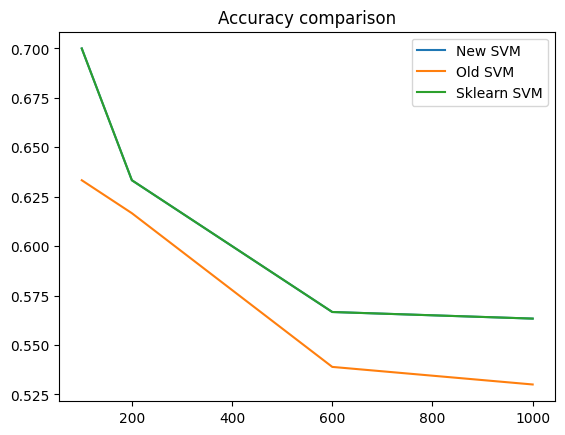

In [30]:
import matplotlib.pyplot as plt
n_real = np.dot(n_test,2)
plt.plot(n_real, acc1, label = 'New SVM')
plt.plot(n_real, acc3, label = 'Old SVM')
plt.plot(n_real, acc4, label = 'Sklearn SVM')
plt.title("Accuracy comparison")
plt.legend()
plt.show()

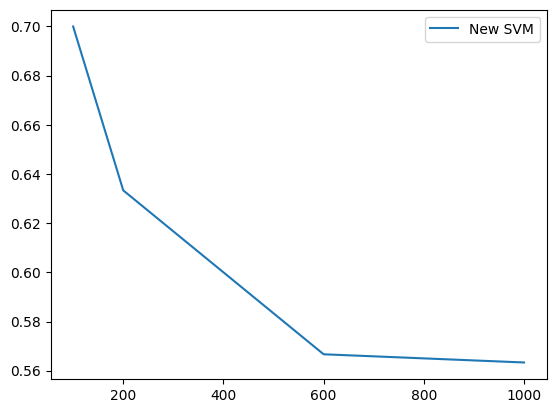

In [31]:
plt.plot(n_real, acc1, label = 'New SVM')
plt.legend()
plt.show()

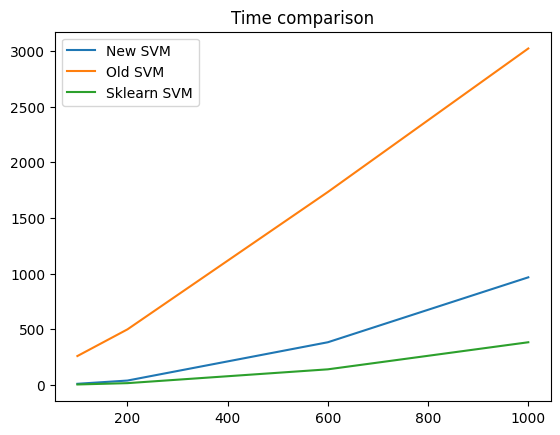

In [32]:
plt.plot(n_real, time1, label = 'New SVM')
plt.plot(n_real, time3, label = 'Old SVM')
plt.plot(n_real, time4, label = 'Sklearn SVM')
plt.title("Time comparison")
plt.legend()
plt.show()

In [17]:
n_test

[50, 100, 300, 500]

In [19]:
print(time1)
print(time2)
print(time3)
print(time4)

[10.660359144210815, 39.787041425704956, 383.8050329685211, 966.7434096336365]
[55.288660287857056, 184.07398915290833, 1694.370008945465, 4375.367433786392]
[259.8548483848572, 499.64973425865173, 1733.3180520534515, 3021.6041758060455]
[4.5094804763793945, 16.51150941848755, 140.60690832138062, 383.6510076522827]


In [21]:
print(acc1)
print(acc2)
print(acc3)
print(acc4)

[0.7, 0.6333333333333333, 0.5666666666666667, 0.5633333333333334]
[0.6, 0.55, 0.5055555555555555, 0.5033333333333333]
[0.6333333333333333, 0.6166666666666667, 0.5388888888888889, 0.53]
[0.7, 0.6333333333333333, 0.5666666666666667, 0.5633333333333334]


In [22]:
import HOG_CUDA_2 as CUDA

In [33]:
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9
threadsperblock = (32,32)
hog = CUDA.HOG(block_size, cell_size, nbins, 40,threadsperblock )

In [38]:
def big_fit(X_train, y_train, hog, svm):
    x_train = []
    t = 0
    for x in X_train:
        #print(t, end="  ")
        x_train.append(hog.compute_HOG(x))
        t+=1
    x_train = np.array(x_train)
    svm.fit(x_train, y_train)

def big_predict(X_test, y_test, hog, svm):
    x_test = []
    t = 0
    for x in X_test:
        #print(t, end = "  ")
        x_test.append(hog.compute_HOG(x))
        t+=1
    x_test = np.array(x_test)
    return svm.predict(x_test)

In [53]:
acc5_HOG = []
time5_HOG = []
acc6_HOG = []
time6_HOG = []

In [56]:
n_test = [50, 100, 300, 500, 600, 1000, 2000, 4000]
link_cat = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Cat\**'
link_dog = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Dog\**'

import time
for n in n_test:
    #--------------------------------------------------------------------------------------------
    X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n)
#     x_train = np.array([x.flatten() for x in X_train])
#     x_test = np.array([x.flatten() for x in X_test])
#     gamma = 1/(x_train.shape[1]*x_train.var())
#     y_train_sklearn = np.array([str(y) for y in y_train])
#     y_test_sklearn = np.array([str(y) for y in y_test])
#     #--------------------------------------------------------------------------------------------
#     print("New SVM")
#     start = time.time()
#     svm = SVM_NEW(C = 1.0, gamma = gamma)
#     big_fit(X_train, y_train, hog, svm)
#     pred = big_predict(X_test, y_test, hog, svm)
#     end = time.time()
#     time1_HOG.append(end-start)
#     acc1_HOG.append(accuracy_score(pred, y_test))
#     #--------------------------------------------------------------------------------------------
    
#     print("Thang SVM")
#     start = time.time()
#     svm = SVM_THANG(C = 1.0)
#     big_fit(X_train, y_train, hog, svm)
#     pred = big_predict(X_test, y_test, hog, svm)
#     end = time.time()
#     time3_HOG.append(end-start)
#     acc3_HOG.append(accuracy_score(pred, y_test))
#     #--------------------------------------------------------------------------------------------
    
#     print("Sklearn SVM")
#     start = time.time()
#     svm = SVC(kernel = 'rbf', C = 1.0, gamma = gamma, )
#     big_fit(X_train, y_train_sklearn, hog, svm)
#     pred = big_predict(X_test, y_test_sklearn, hog, svm)
#     end = time.time()
#     time4_HOG.append(end-start)
#     acc4_HOG.append(accuracy_score(pred, y_test_sklearn))
        
    print("Parallel SVM - rbf",n)
    start = time.time()
    svm = SVM_Pa()
    big_fit(X_train, y_train, hog, svm)
    pred = big_predict(X_test, y_test, hog, svm)
    end = time.time()
    time5_HOG.append(end-start)
    acc5_HOG.append(accuracy_score(pred, y_test))
    
    print("Parallel SVM - linear",n)
    start = time.time()
    svm = SVM_Pa(kernel="linear")
    big_fit(X_train, y_train, hog, svm)
    pred = big_predict(X_test, y_test, hog, svm)
    end = time.time()
    time6_HOG.append(end-start)
    acc6_HOG.append(accuracy_score(pred, y_test))
      

Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cud

Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 14 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 84 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 84 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 22 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 27 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 44 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 88 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


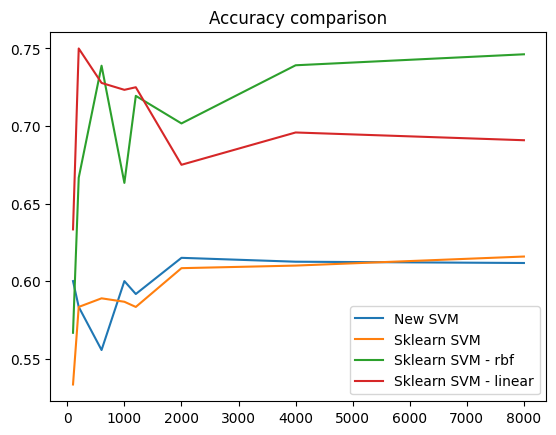

In [61]:
import matplotlib.pyplot as plt
n_real = np.dot([50, 100, 300, 500, 600, 1000 ,2000,4000],2)
plt.plot(n_real, acc1_HOG, label = 'New SVM')
#plt.plot(n_real, acc3_HOG, label = 'Old SVM')
plt.plot(n_real, acc4_HOG, label = 'Sklearn SVM')
plt.plot(n_real, acc5_HOG, label = 'Sklearn SVM - rbf')
plt.plot(n_real, acc6_HOG, label = 'Sklearn SVM - linear')
plt.title("Accuracy comparison")
plt.legend()
plt.show()

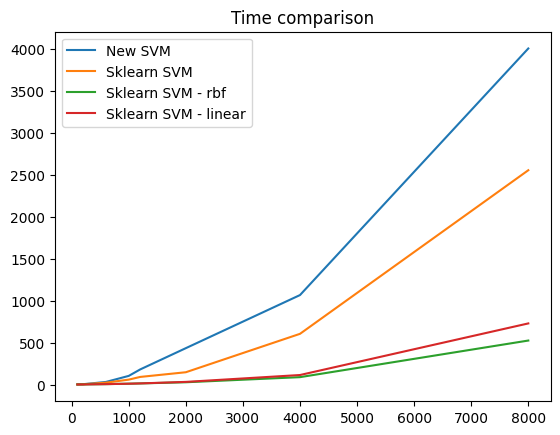

In [60]:
plt.plot(n_real, time1_HOG, label = 'New SVM')
#plt.plot(n_real, time3_HOG, label = 'Old SVM')
plt.plot(n_real, time4_HOG, label = 'Sklearn SVM')
plt.plot(n_real, time5_HOG, label = 'Sklearn SVM - rbf')
plt.plot(n_real, time6_HOG, label = 'Sklearn SVM - linear')
plt.title("Time comparison")
plt.legend()
plt.show()

In [62]:
print(n_real, acc4_HOG,'Sklearn SVM')
print(n_real, acc5_HOG,'Sklearn SVM - rbf')
print(n_real, acc6_HOG,'Sklearn SVM - linear')

[ 100  200  600 1000 1200 2000 4000 8000] [0.5333333333333333, 0.5833333333333334, 0.5888888888888889, 0.5866666666666667, 0.5833333333333334, 0.6083333333333333, 0.61, 0.6158333333333333] Sklearn SVM
[ 100  200  600 1000 1200 2000 4000 8000] [0.5666666666666667, 0.6666666666666666, 0.7388888888888889, 0.6633333333333333, 0.7194444444444444, 0.7016666666666667, 0.7391666666666666, 0.74625] Sklearn SVM - rbf
[ 100  200  600 1000 1200 2000 4000 8000] [0.6333333333333333, 0.75, 0.7277777777777777, 0.7233333333333334, 0.725, 0.675, 0.6958333333333333, 0.6908333333333333] Sklearn SVM - linear


In [63]:
print(n_real, time4_HOG,'Sklearn SVM')
print(n_real, time5_HOG,'Sklearn SVM - rbf')
print(n_real, time6_HOG,'Sklearn SVM - linear')

[ 100  200  600 1000 1200 2000 4000 8000] [0.860213041305542, 3.1859376430511475, 22.32470393180847, 58.67563462257385, 90.7392041683197, 146.63935446739197, 604.049825668335, 2552.6605722904205] Sklearn SVM
[ 100  200  600 1000 1200 2000 4000 8000] [1.499901294708252, 1.640934944152832, 4.948013067245483, 10.391630172729492, 13.427524328231812, 27.29010558128357, 88.10140776634216, 524.0977566242218] Sklearn SVM - rbf
[ 100  200  600 1000 1200 2000 4000 8000] [0.906245231628418, 1.2371387481689453, 4.93492865562439, 9.879064798355103, 13.465924263000488, 31.59050178527832, 113.52655172348022, 728.0858979225159] Sklearn SVM - linear
